Semiclassical corrections present : $\tilde{t} \ne 0$

What does the code do ?

This code takes the CORRECTED metric and checks what happens (falls or escapes) to the photon starting tangentially at a distance $r = 1.5r_s(1+10^{-8})$.

In [107]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

In [108]:
# --- Physical Constants in SI units ---
G = 6.67430e-11         # m^3 kg^-1 s^-2
c = 2.99792458e8        # m/s
M_sun = 1.989e30        # kg
AU = 1.496e11           # m

# Schwarzschild radius
r_s = 2 * G * M_sun / c**2
r_s2_inv = 1 / r_s**2

In [109]:
# Semiclassical perturbation
t_tilde = 1e-7
# t_tilde = 0

In [110]:
# Critical distances
P_c = 1.5 * r_s * (1 + (2.03 / 3) * t_tilde)
b_c = (3 * np.sqrt(3) / 2) * r_s * (1 + 0.8066 * t_tilde)
zeta_sq = (r_s / b_c)**2

In [111]:
# --- Mathematical functions ---
@njit
def coth(z):
    return 1.0 / np.tanh(z)

@njit
def htt(x):
    inv_x2 = 1.0 / (x * x)
    return -2 * x**3 * (x**2 - coth(inv_x2))

@njit
def hrr(x):
    inv_x2 = 1.0 / (x * x)
    denom = (1 - x)**2
    return -2 * x**2 / denom * (x**2 - coth(inv_x2))

@njit
def hphiphi(x):
    return -2 * r_s**2 / x * (x - coth(1.0 / x))

@njit
def g0(x):
    return x**3 - x**2 + zeta_sq

@njit
def dg0(x):
    return 3 * x**2 - 2 * x

@njit
def h(x):
    g = g0(x)
    h_rr = hrr(x)
    h_pp = hphiphi(x)
    h_tt = htt(x)

    term1 = g * ((1 - x) * h_rr - x**2 * r_s2_inv * h_pp)
    term2 = -zeta_sq * (x**2 * r_s2_inv * h_pp - h_tt / (1 - x))
    return term1 + term2

@njit
def dh(x):
    dx = 1e-11
    return (h(x + dx) - h(x - dx)) / (2 * dx)

In [112]:
# --- ODE System and RK4 ---
@njit
def deriv(y):
    x, v = y
    return np.array([v, 0.5 * (dg0(x) + t_tilde * dh(x))])

@njit
def rk4_step(y, h):
    k1 = h * deriv(y)
    k2 = h * deriv(y + 0.5 * k1)
    k3 = h * deriv(y + 0.5 * k2)
    k4 = h * deriv(y + k3)
    return y + (k1 + 2*k2 + 2*k3 + k4) / 6.0

@njit
def integrate_rk4(y_ini, phis, h_phi):
    N = len(phis)
    ys = np.empty((N, 2))
    y = y_ini.copy()
    for i in range(N):
        ys[i] = y
        y = rk4_step(y, h_phi)
    return ys

In [113]:
# Initial conditions
x0 = 1/(1.5+10**-8)

v0 = 0.0
y_ini = np.array([x0, v0])

# Integration setup
n_revolutions = 3
# h_phi = 1e-7
h_phi = 10**-5
phis = np.arange(0, 2 * np.pi * n_revolutions, h_phi)

In [114]:
# --- Run Integration ---
ys = integrate_rk4(y_ini, phis, h_phi)
xs = ys[:, 0]
r_vals = r_s / xs
r_vals_AU = r_vals / AU

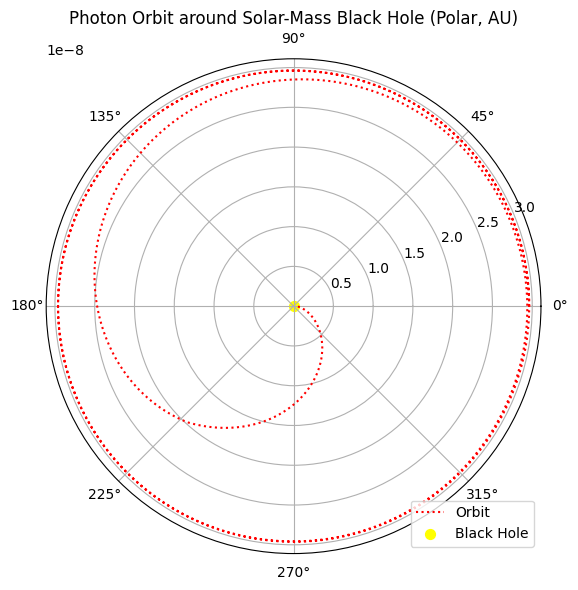

In [115]:
# --- Plotting ---
# Polar plot
# Downsample for plotting only
max_points = 100_000  # Cap the number of points to plot
if len(phis) > max_points:
    idxs = np.linspace(0, len(phis) - 1, max_points, dtype=int)
    phis_plot = phis[idxs]
    r_plot = r_vals_AU[idxs]
else:
    phis_plot = phis
    r_plot = r_vals_AU

# Plot
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
ax.plot(phis_plot, r_plot, color='red', linestyle='dotted', label='Orbit')
ax.scatter([0], [0], color='yellow', label='Black Hole', s=50)  # smaller marker
ax.set_title("Photon Orbit around Solar-Mass Black Hole (Polar, AU)")
ax.legend()
plt.tight_layout()
plt.show()

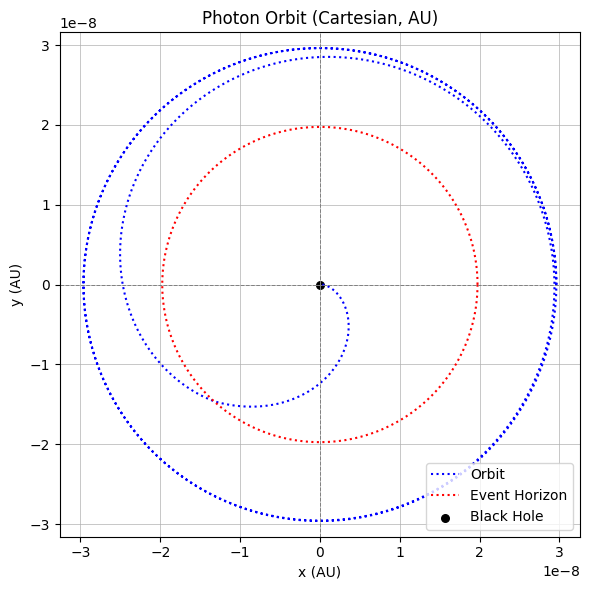

In [116]:
# Cartesian plot
# Downsample orbit data if too large
max_points = 100_000
if len(phis) > max_points:
    idxs = np.linspace(0, len(phis) - 1, max_points, dtype=int)
    r_plot = r_vals_AU[idxs]
    phi_plot = phis[idxs]
else:
    r_plot = r_vals_AU
    phi_plot = phis

# Cartesian coordinates
x_cart = r_plot * np.cos(phi_plot)
y_cart = r_plot * np.sin(phi_plot)

# Event horizon circle (fixed resolution)
theta_circle = np.linspace(0, 2*np.pi, 300)
x_event = (r_s * np.cos(theta_circle)) / AU
y_event = (r_s * np.sin(theta_circle)) / AU

# Plot
plt.figure(figsize=(6, 6))
plt.plot(x_cart, y_cart, color='blue', linestyle='dotted', label='Orbit')
plt.plot(x_event, y_event, 'r:', label="Event Horizon")
plt.axhline(0, linestyle='dashed', color='gray', linewidth=0.7)
plt.axvline(0, linestyle='dashed', color='gray', linewidth=0.7)
plt.scatter([0], [0], color='black', label='Black Hole', s=30)
plt.xlabel("x (AU)")
plt.ylabel("y (AU)")
plt.axis('equal')
plt.title("Photon Orbit (Cartesian, AU)")
plt.legend()
plt.grid(True, linewidth=0.5)
plt.tight_layout()
plt.show()

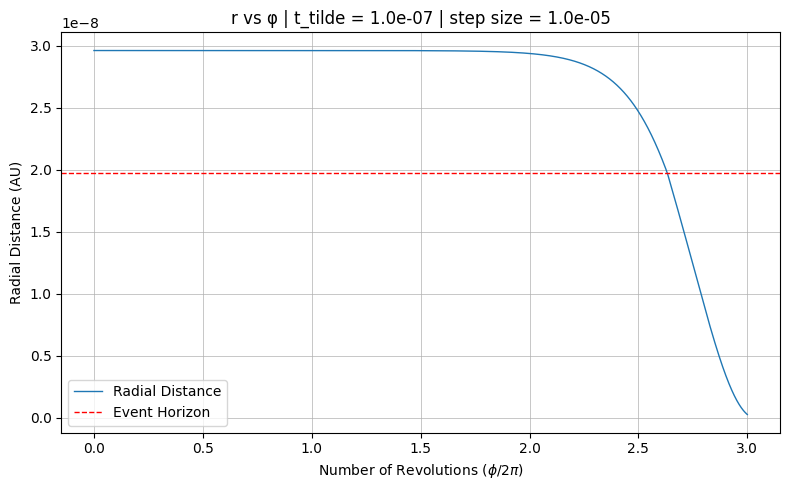

In [117]:
# r(φ) vs φ
# Downsample if needed
max_points = 100_000
if len(phis) > max_points:
    idxs = np.linspace(0, len(phis) - 1, max_points, dtype=int)
    phi_plot = phis[idxs]
    r_plot = r_vals_AU[idxs]
else:
    phi_plot = phis
    r_plot = r_vals_AU

# Plot
plt.figure(figsize=(8, 5))
plt.plot(phi_plot / (2 * np.pi), r_plot, label="Radial Distance", linewidth=1)
plt.axhline(r_s / AU, color='red', linestyle='dashed', label="Event Horizon", linewidth=1)
plt.title(f"r vs φ | t_tilde = {t_tilde:.1e} | step size = {h_phi:.1e}")
plt.xlabel("Number of Revolutions ($\\phi / 2\\pi$)")
plt.ylabel("Radial Distance (AU)")
plt.legend()
plt.grid(True, linewidth=0.5)
plt.tight_layout()
plt.show()

In [118]:
# Summary Output
print("Minimum radial distance (m):", AU * max(np.min(r_vals_AU),0))
print("Schwarzschild radius (m):", r_s)
print("Photon captured by black hole" if AU * np.min(r_vals_AU) < r_s else "Photon didn't fall in black hole")

Minimum radial distance (m): 41.68174461541717
Schwarzschild radius (m): 2954.126555055405
Photon captured by black hole
